In [1]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('dbUrl')

In [2]:
# to filter for GitHub only: where repo_url LIKE '%%github%%'
population = "top_10k"
repos = pd.read_sql_query("select distinct repo_url from repo_tags_2 where population = %s", params=[population], con=engine)

In [3]:
%%time
import processing
import utils

timeToUsageMap = {}
languages = set(["CoffeeScript", "TypeScript", "Elm", "ActionScript", "PureScript"])

def countFunc(commitHash, engine):
    counts = {}
    query = """select distinct check_id as langs from sloccount_results where commit_hash = %s"""
    calls = pd.read_sql_query(query, params=[commitHash], con=engine)
    # check here whether browser or node api is used
    for l in calls['langs']:
        if l in languages:
            counts[l] = 1
            hasLang = True
    return counts  

def completionFunc(x):
    timeMap = x.result()
    for d, counts in timeMap.items():
        for l, c in counts.items():
            if d not in timeToUsageMap:
                timeToUsageMap[d] = {}
            if l in timeToUsageMap[d]:
                if c > 0:
                    timeToUsageMap[d][l] = timeToUsageMap[d][l] + 1
            else:
                if c > 0:
                    timeToUsageMap[d][l] = 1
                else:
                    timeToUsageMap[d][l] = 0
                
utils.runInParallelCommitProcessing(processing.processCommitsReleaseTime, repos, countFunc, processing.normalizekLoC, completionFunc)

Progress: 8/9988
Progress: 7/9988
Progress: 2/9988
Progress: 4/9988
Progress: 1/9988
Progress: 12/9988
Progress: 10/9988
Progress: 13/9988
Progress: 6/9988
Progress: 14/9988
Progress: 5/9988
Progress: 11/9988
Progress: 15/9988
Progress: 18/9988
Progress: 16/9988
Progress: 9/9988
Progress: 17/9988
Progress: 22/9988
Progress: 24/9988
Progress: 19/9988
Progress: 20/9988
Progress: 27/9988
Progress: 28/9988
Progress: 23/9988
Progress: 29/9988
Progress: 31/9988
Progress: 21/9988
Progress: 26/9988
Progress: 25/9988
Progress: 35/9988
Progress: 34/9988
Progress: 37/9988
Progress: 40/9988
Progress: 33/9988
Progress: 36/9988
Progress: 32/9988
Progress: 3/9988
Progress: 43/9988
Progress: 38/9988
Progress: 41/9988
Progress: 42/9988
Progress: 30/9988
Progress: 39/9988
Progress: 47/9988
Progress: 45/9988
Progress: 49/9988
Progress: 52/9988
Progress: 51/9988
Progress: 55/9988
Progress: 53/9988
Progress: 57/9988
Progress: 50/9988
Progress: 48/9988
Progress: 56/9988
Progress: 54/9988
Progress: 60/9988
P

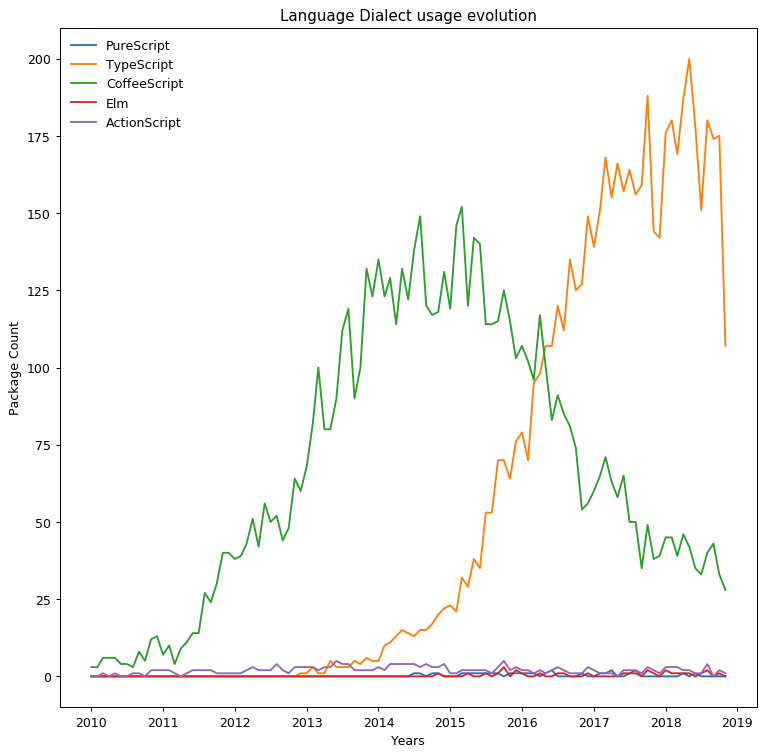

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

plt.figure(figsize=(10,10), dpi=90)
plt.xlabel("Years")
plt.ylabel('Package Count')
plt.title("Language Dialect usage evolution")

for language in languages:
    dates = []
    values = []
    for y in range(2010,2019):
        for m in range(1,13):
            date = (y,m)
            if date in timeToUsageMap:
                dates.append(datetime.datetime(y,m, 1))
                monthSum = 0
                if language in timeToUsageMap[date]:
                    monthSum = timeToUsageMap[date][language]
                values.append(monthSum)
    plt.plot(dates, values, label=language)
    
plt.legend(loc='best', frameon=False)

plt.savefig('figures/languageEvolution_releasetime_{}.png'.format(population))

plt.show()